<img src="https://i.imgur.com/1lX7uZl.png">

<center><h1> Detect AI Generated text </h1></center>
<center><h1>- Classify using DistilBERT -</h1></center>

> 📌 **Competition Scope**: the goal of the competition is to determine whether or not essay was generated by an LLM.

### ○ References
* Additional generated train data from Radek's dataset: [🤖 LLM Generated Essays for the Detect AI Comp!](https://www.kaggle.com/datasets/radek1/llm-generated-essays/)
* [Big Vocab Words](https://www.berlitz.com/blog/big-words-to-sound-smart)
* [Transitional Words](https://www.touro.edu/departments/writing-center/tutorials/transitional-words/#:~:text=and%2C%20again%2C%20and%20then%2C,first%20(second%2C%20etc.))

### ○ Libraries

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Notebook Color Schemes:


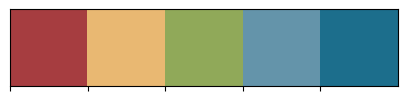

In [1]:
# libraries
import os
import gc
import wandb
import random
import json
import string
import re
from tqdm import tqdm
from time import time
import warnings
import pandas as pd
import numpy as np
from collections import Counter
import string

# visuals
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# env check
warnings.filterwarnings('ignore')
os.environ["WANDB_SILENT"] = "true"

COMP_ID = '2023_detect_gen_text'
CONFIG = {'competition': COMP_ID, '_wandb_kernel': 'aot', "source_type": "artifact"}

# color
class clr:
    S = '\033[1m' + '\033[90m'
    E = '\033[0m'
my_colors = ["#A63D40", "#E9B872", "#90A959", "#6494AA", "#1C6E8C"]

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

### 🐝 W&B Fork & Run

In order to run this notebook you will need to input your own **secret API key** within the `! wandb login $secret_value_0` line. 

🐝**How do you get your own API key?**

Super simple! Go to **https://wandb.ai/site** -> Login -> Click on your profile in the top right corner -> Settings -> Scroll down to API keys -> copy your very own key (for more info check [this amazing notebook for ML Experiment Tracking on Kaggle](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases)).

<center><img src="https://i.imgur.com/fFccmoS.png" width=500></center>

In [2]:
# 🐝 secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_KEY = user_secrets.get_secret("wandb")

! wandb login $WANDB_KEY

### ○ Helper Functions Below

In [3]:
def calculate_repetitiveness(text):
    # clean text
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator).lower()

    # tokenize
    words = text.split()

    # count the occurrences of each word
    word_counts = Counter(words)

    # compute repetitiveness
    total_words = len(words)
    unique_words = len(word_counts)
    repetitiveness = 1 - (unique_words / total_words) if total_words > 0 else 0

    return repetitiveness


def calculate_vocabulary_score(text, vocab):
    # clean text
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator).lower()

    # tokenize
    words = text.split()

    # count the occurrences of each word
    word_counts = Counter(words)

    # compute score based on vocabulary
    total_words = len(words)
    vocab_occurrences = sum(word_counts[word] for word in vocab)
    score = vocab_occurrences / total_words if total_words > 0 else 0

    return score


# === plots ===
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
# === 🐝 w&b ===
def save_dataset_artifact(run_name, artifact_name, path, data_type="dataset"):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project=COMP_ID, 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type=data_type)
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print(f"🐝Artifact {artifact_name} has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [4]:
# 🐝
run = wandb.init(project=COMP_ID, name='cover', config=CONFIG)
cover = plt.imread("/kaggle/input/english-vocabulary-miscellaneous/cover.png")
wandb.log({"example": wandb.Image(cover)})
wandb.finish()

# 1. Data Explore

**📌 TL;DR:**
* As the comp data has (almost) only texts made by pupils and only 3 generated I am combining the data from Radek
* We end up with 703 generated texts and 1375 real texts
* The texts are evenly distributed between the 2 prompts within this comp.

In [5]:
# retrieve comp data
train_comp = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train_prompts = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")

# retrieve additional data
train_gen1 = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv")
train_gen2 = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv")
train_gen = pd.concat([train_gen1, train_gen2], axis=0)\
                .reset_index(drop=True)

In [6]:
train_comp.head(3)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0


In [7]:
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [8]:
train_gen.head(3)

,id,prompt_id,text,generated
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1


-> Number of total unique IDs in comp train data:  1378
-> Our dataset has only 3 generated values and the rest 1375 texts are written by pupils. 



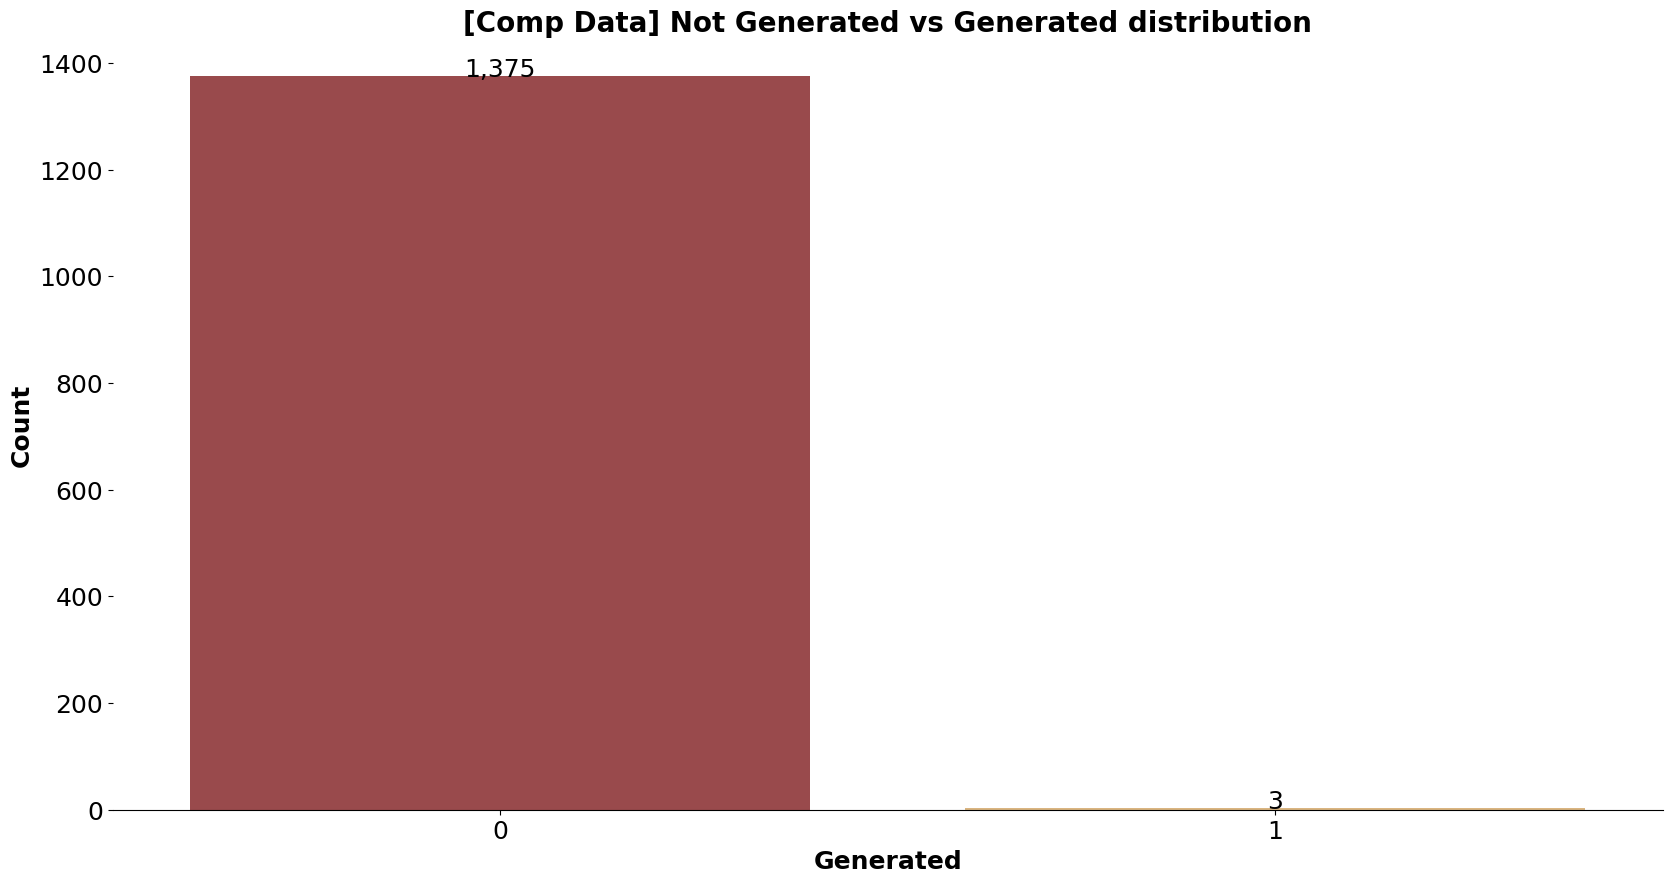

In [9]:
# data shape
print(clr.S+"-> Number of total unique IDs in comp train data: "+clr.E,
      train_comp.id.nunique())

# plot
print(clr.S+"-> Our dataset has only 3 generated values and the rest 1375 texts are written by pupils."+clr.E,
      "\n")
plt.figure(figsize=(20, 10))
figure = sns.countplot(data=train_comp,
                       x="generated",palette=my_colors)
show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[Comp Data] Not Generated vs Generated distribution',
          weight="bold", size=20)

plt.xlabel("Generated", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True)
plt.show();

-> The 2 types of prompts that were asked in this comp are:
Prompt 0 
 prompt_name: Car-free cities 
 instructions: Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided. 
 source_text: # In German Suburb, Life Goes On Without ... 

Prompt 1 
 prompt_name: Does the electoral college work? 
 instructions: Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage y

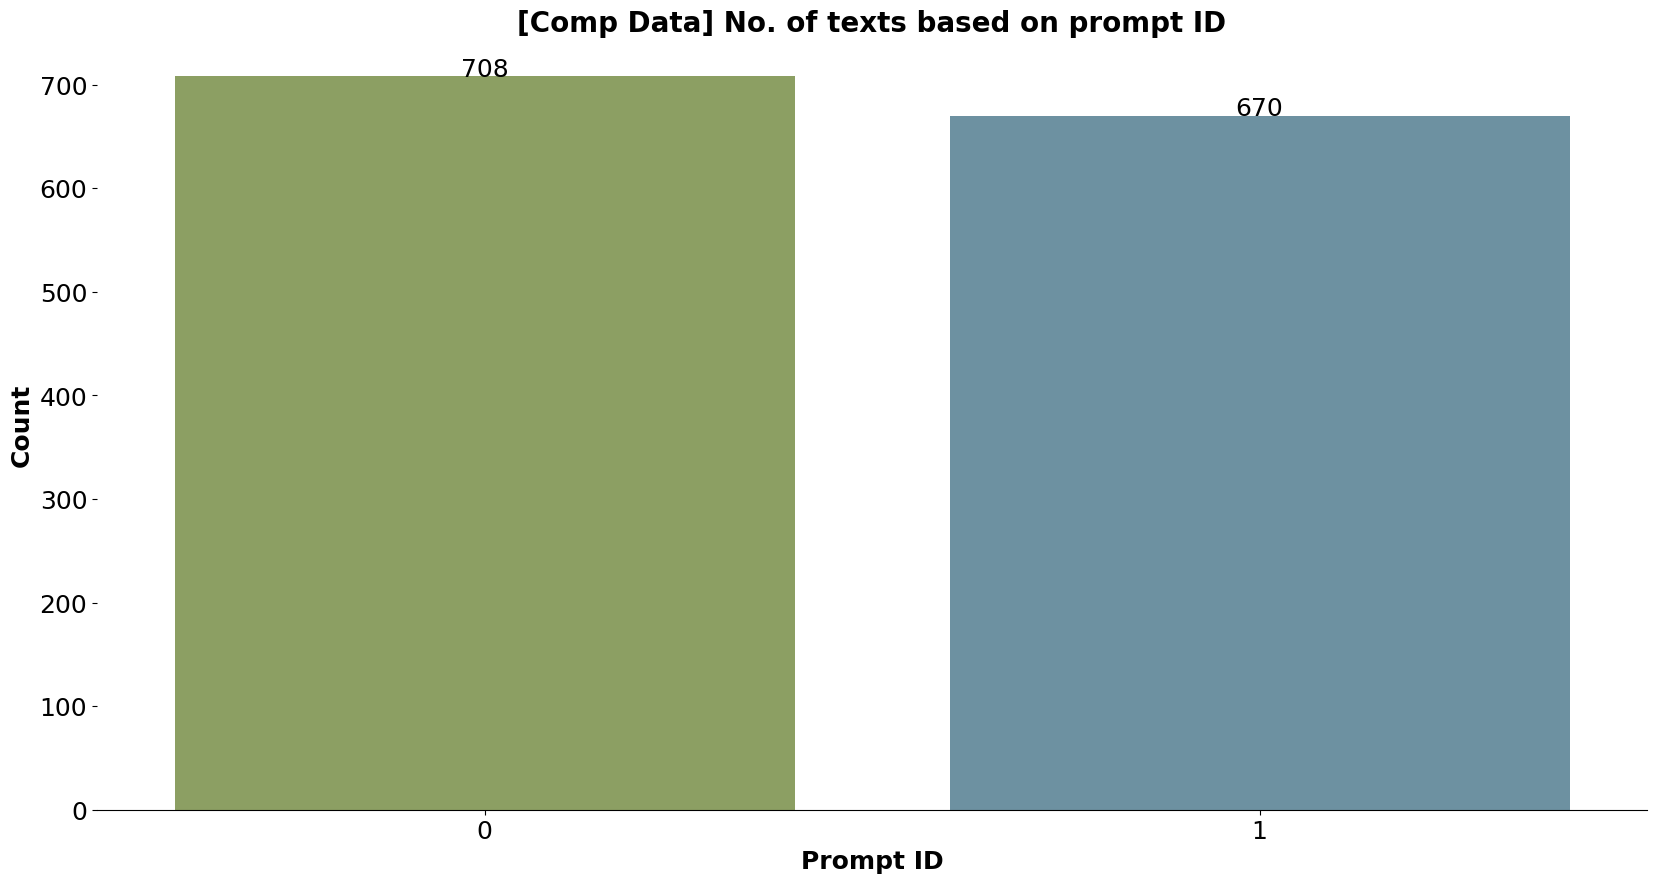

In [10]:
# prompt analysis
print(clr.S+"-> The 2 types of prompts that were asked in this comp are:"+clr.E)
for k in range(len(train_prompts)):
    info = train_prompts.loc[k, :]
    print(clr.S+f"Prompt {k}"+clr.E, "\n",
          clr.S+"prompt_name:"+clr.E, info.prompt_name, "\n",
          clr.S+"instructions:"+clr.E, info.instructions, "\n",
          clr.S+"source_text:"+clr.E, info.source_text[:40], "...", "\n")
    
# plot
print(clr.S+"-> The types of responses based on prompt ID is fairly evenly distributed."+clr.E,
      "\n")
plt.figure(figsize=(20, 10))
figure = sns.countplot(data=train_comp,
                       x="prompt_id",palette=my_colors[2:])
show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[Comp Data] No. of texts based on prompt ID',
          weight="bold", size=20)

plt.xlabel("Prompt ID", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True)
plt.show();

-> We have 700 more generated data from Radek. 



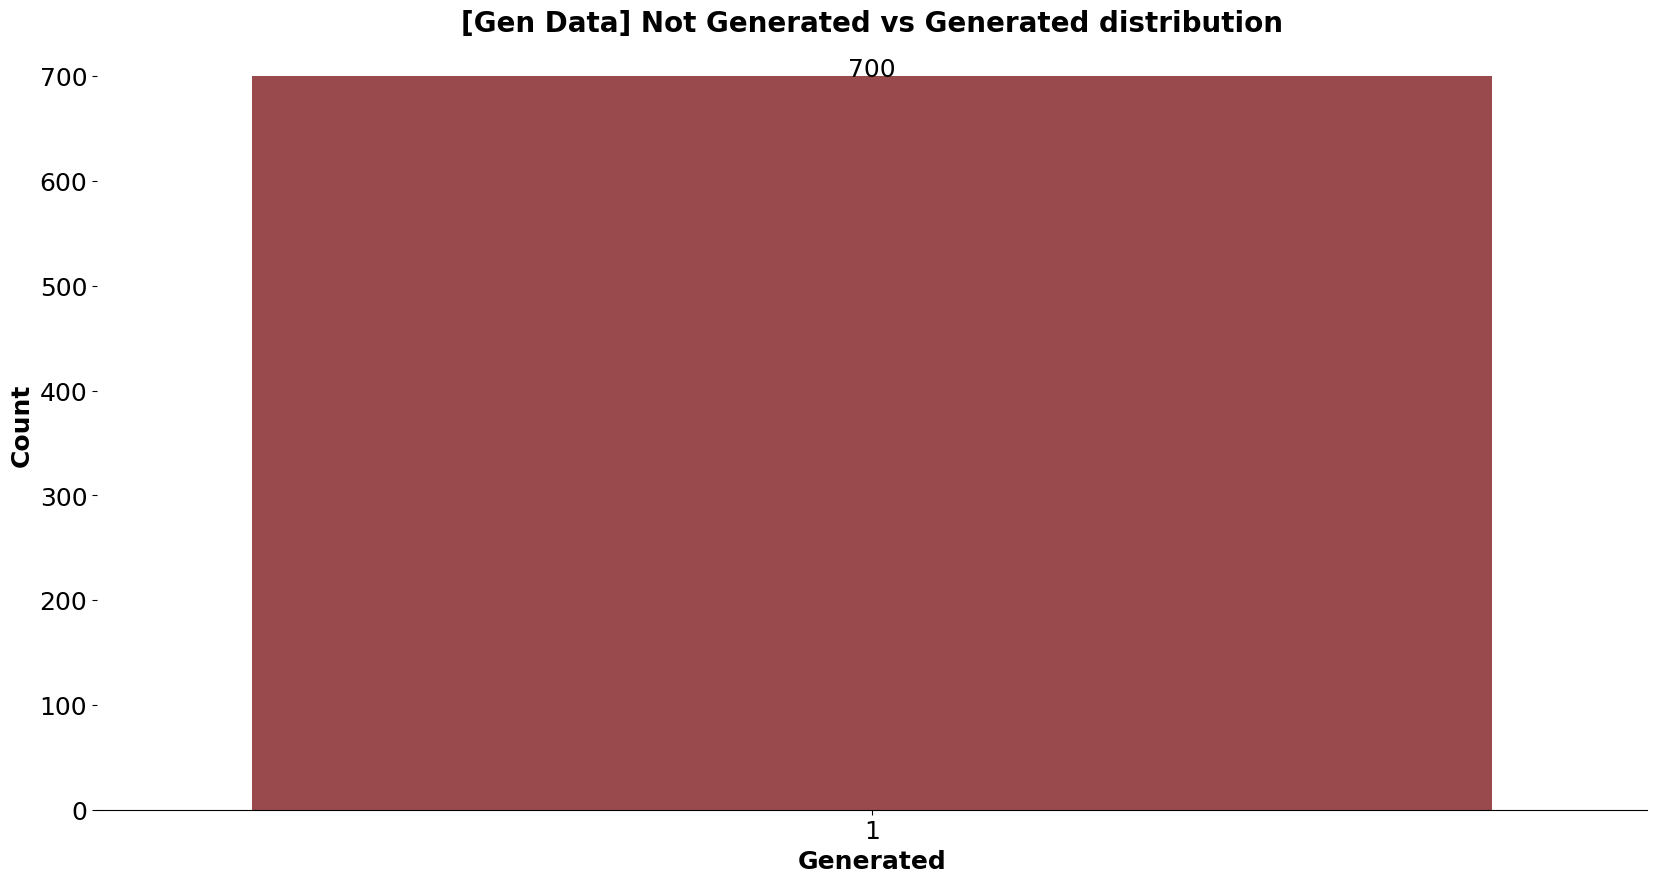

-> And the prompts are evenly distributed! We can get to work :) 



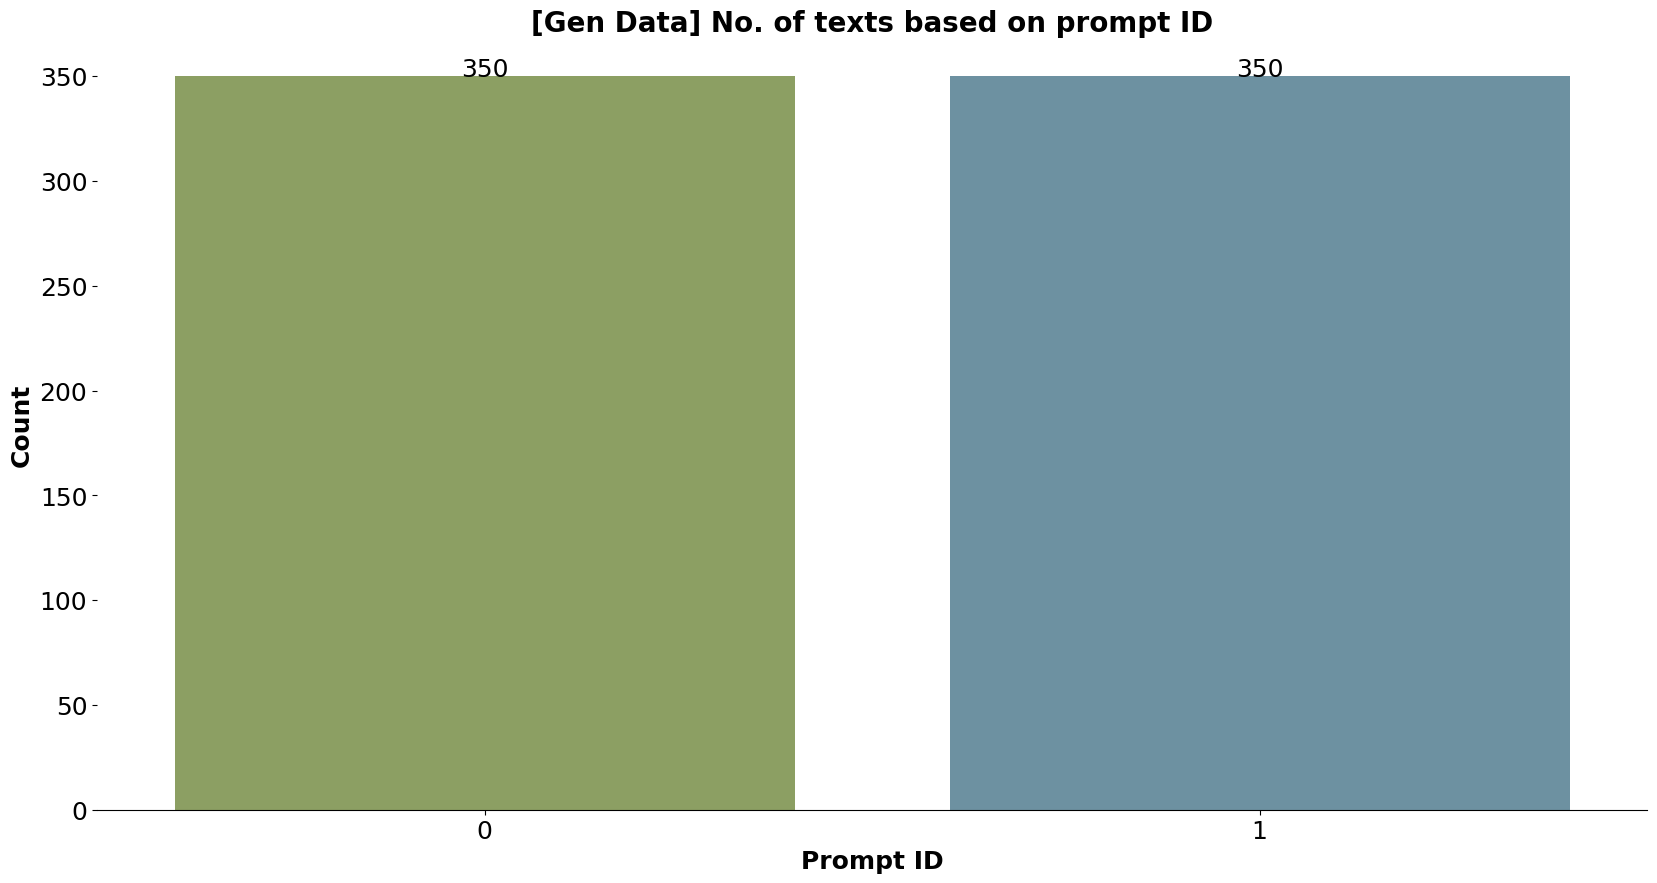

In [11]:
# plot 1
print(clr.S+"-> We have 700 more generated data from Radek."+clr.E,
      "\n")
plt.figure(figsize=(20, 10))
figure = sns.countplot(data=train_gen,
                       x="generated",palette=my_colors)
show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[Gen Data] Not Generated vs Generated distribution',
          weight="bold", size=20)

plt.xlabel("Generated", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True)
plt.show();

# plot 2
print(clr.S+"-> And the prompts are evenly distributed! We can get to work :)"+clr.E,
      "\n")
plt.figure(figsize=(20, 10))
figure = sns.countplot(data=train_gen,
                       x="prompt_id",palette=my_colors[2:])
show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[Gen Data] No. of texts based on prompt ID',
          weight="bold", size=20)

plt.xlabel("Prompt ID", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True)
plt.show();

In [12]:
# combine the datasets
train_final = pd.concat([train_comp, train_gen], axis=0)\
                        .reset_index(drop=True)

# 2. Comparison between Gen & Not Gen

Here are some [traditional ways to spot if a text was generated by AI](https://goldpenguin.org/blog/check-for-ai-content/#:~:text=Repetition%20of%20words%20and%20phrases,know%20what%20it's%20talking%20about):
1. *Watch out for Transitional Words* -> like Furthermore, Additionally, Moreover, Consequently, Hence etc.
2. *Big vocab words are suspicious* -> like Utilized, Implemented, Leveraged, Elucidated, and Ascertained
3. *Repetition of words and phrases* -> look for repetition of words and phrases (aka – it doesn't really know what it's talking about)

Let us test these claims in our text to see if they are true:
* transitional words - for the selected trans words vocab it looks like the 2 distributions are the same -> aka no difference spotted.
* big words vocab - no conclusion, as there are too fiew vocab words found within both generated and not generated text
* repetitive words - it looks like it's the exact opposite from the initial reasoning, as there is more repetition in the non generated text vs generated one
    * I would conclude this is the case because the non generated text is written by children and teens - hence their vocabulary and reasoning is still developing, so their repetition is higher
    
**📌 TL;DR:**
* we might want to include `repetition_score` within our model, as it may contain valuable info. 

In [13]:
# import premade dictionaries
trans_words = json.load(open("/kaggle/input/english-vocabulary-miscellaneous/transitional_words.json"))
big_words = json.load(open("/kaggle/input/english-vocabulary-miscellaneous/big_vocab_words.json"))


# compute scores
train_final["transitional_score"] = train_final.text.apply(lambda x: 
                                                           calculate_vocabulary_score(x, trans_words))
train_final["big_vocab_score"] = train_final.text.apply(lambda x: 
                                                        calculate_vocabulary_score(x, big_words))
train_final["repetition_score"] = train_final.text.apply(lambda x: 
                                                         calculate_repetitiveness(x))

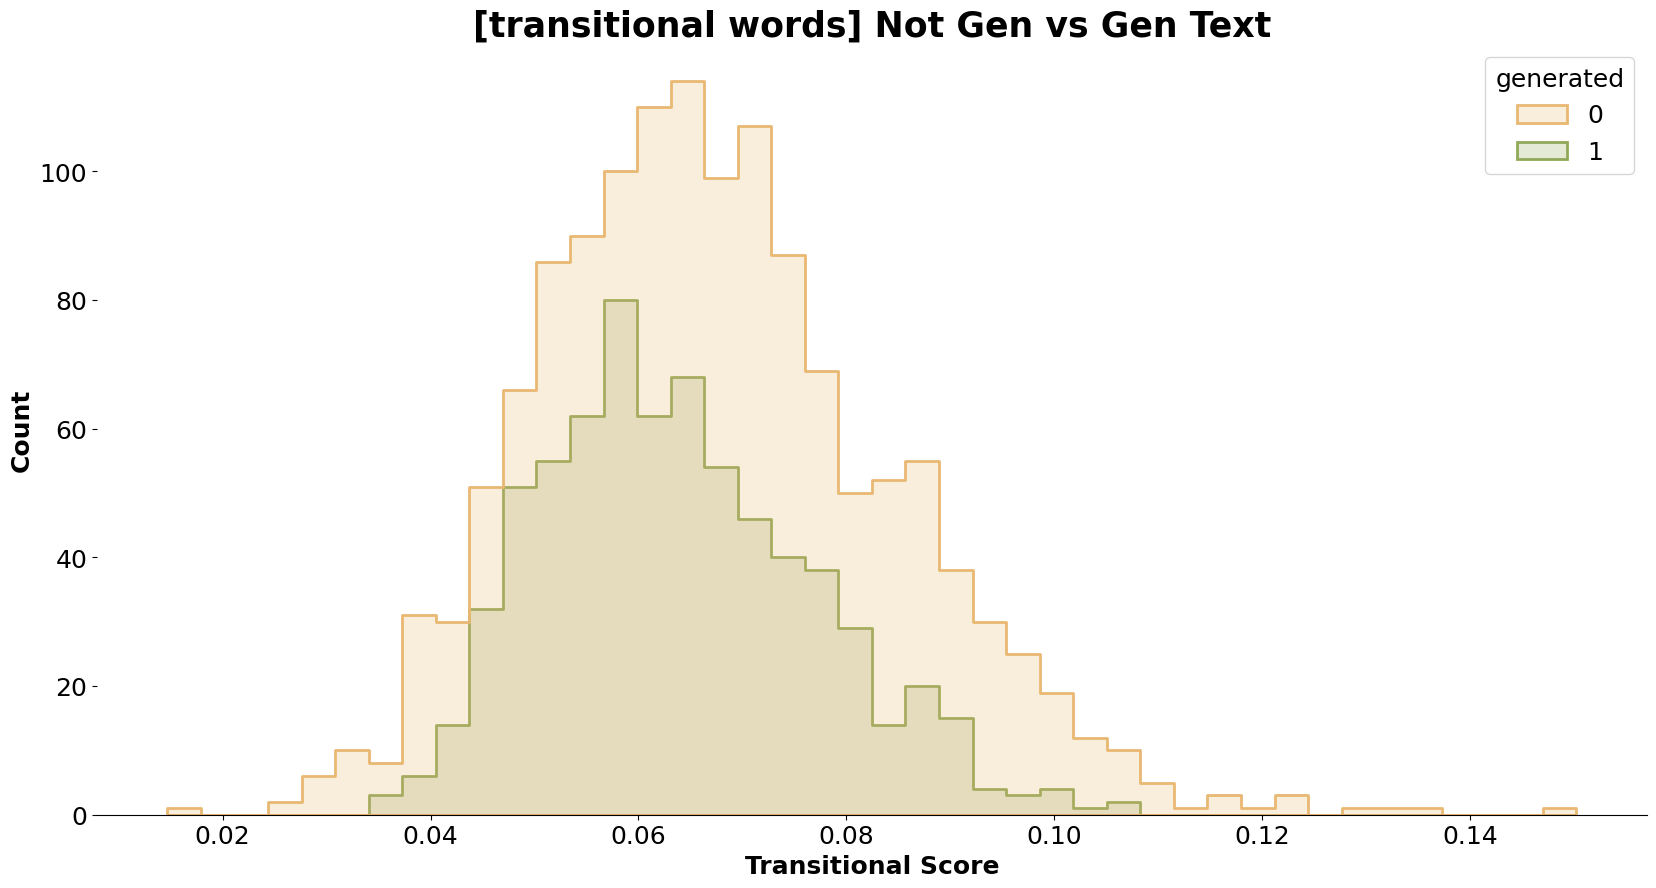

In [14]:
plt.figure(figsize=(20, 10))
sns.histplot(data=train_final, x="transitional_score", 
             hue="generated",
             element="step",
             palette=my_colors[1:], 
             lw=2,)

plt.xlabel("Transitional Score", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")

plt.title("[transitional words] Not Gen vs Gen Text", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

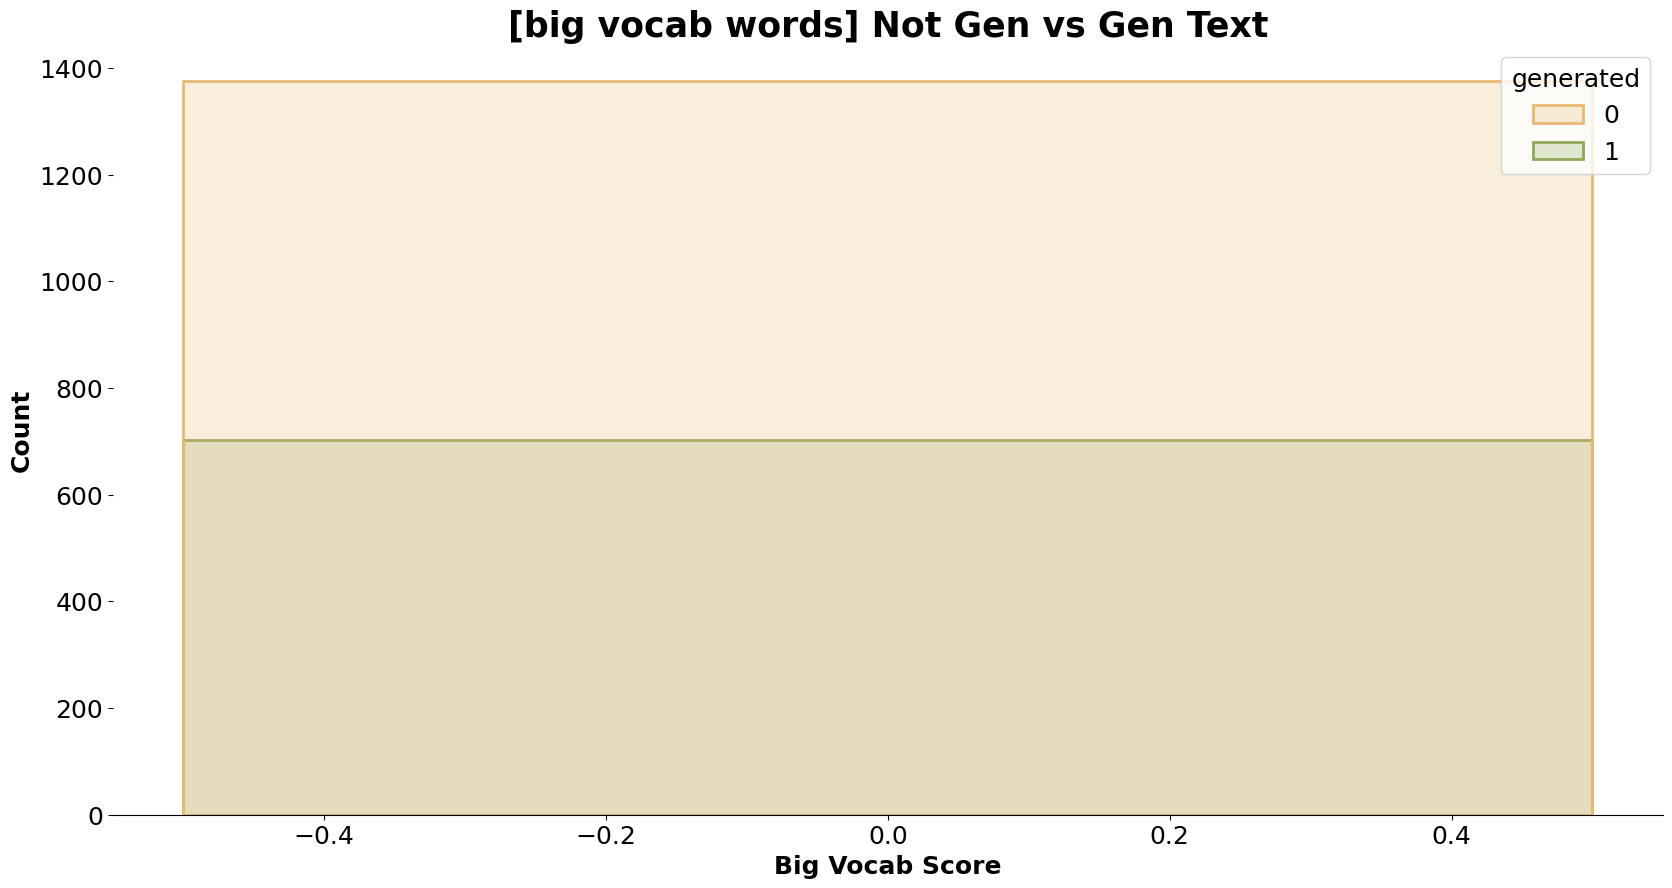

In [15]:
plt.figure(figsize=(20, 10))
sns.histplot(data=train_final, x="big_vocab_score", 
             hue="generated",
             element="step",
             palette=my_colors[1:], 
             lw=2,)

plt.xlabel("Big Vocab Score", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")

plt.title("[big vocab words] Not Gen vs Gen Text", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

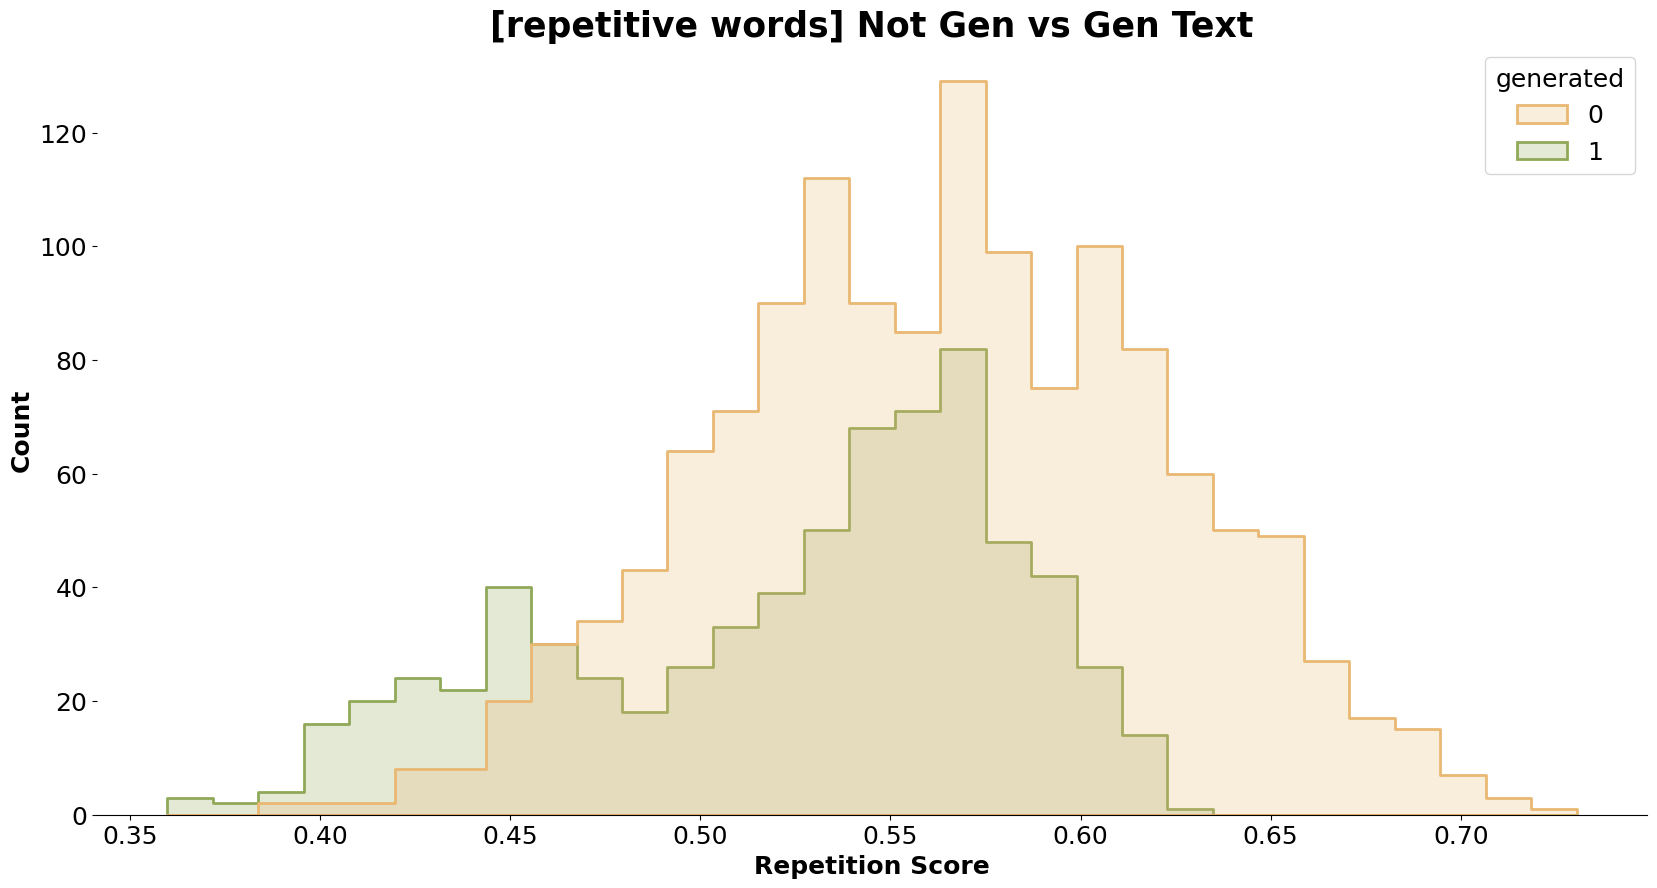

In [16]:
plt.figure(figsize=(20, 10))
sns.histplot(data=train_final, x="repetition_score", 
             hue="generated",
             element="step",
             palette=my_colors[1:], 
             lw=2,)

plt.xlabel("Repetition Score", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")

plt.title("[repetitive words] Not Gen vs Gen Text", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

# 3. Parameters Initialization

* https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
* https://www.sabrepc.com/blog/Deep-Learning-and-AI/Hugging-Face-Text-Classification-Tutorial-PyTorch

### ○ Initial Setup

In [17]:
from nltk.corpus import stopwords 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn as nn

# BERT
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
import transformers
transformers.logging.set_verbosity_error()

# reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


STOPWORDS = set(stopwords.words('english'))
DEVICE = torch.device('cuda:0')
print(clr.S+"Device: "+clr.E, DEVICE)

Device:  cuda:0


### ○ Global Parameters

In [18]:
# ~~~~~~~~~~~~~ PARAMS ~~~~~~~~~~~~~
SEED = 24
MAX_LEN = 512
LAYER_SIZE = 768
NVALID = 0.3
LR = 0.005
BATCH_SIZE = 16    # 32 gets OOO in this environment :)
EPOCHS = 2

BERT_MODEL = 'bert-base-uncased'
# BERT_MODEL = 'distilbert-base-uncased'
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# 4. Text Cleanup

In [19]:
def clean_text(input_text):
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = input_text.translate(translator)
    # remove multiple spaces (replace with a single space)
    cleaned_text = re.sub(r'\s+', ' ', text_no_punct)
    # lower case
    cleaned_text = cleaned_text.lower()

    return cleaned_text

### ○ How the function works:

In [20]:
print(clr.S+ "Original:" +clr.E)
print(train_final["text"][0][:1000],"\n")

print(clr.S+ "Cleaned:" +clr.E)
print(clean_text(train_final["text"][0][:1000]))

Original:
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. 

# 5. Dataset

In [21]:
class GenDataset(Dataset):
    
    def __init__(self, data, max_len):
        super().__init__()
        
#         self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
        self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
        self.max_len = max_len
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        # get data by index
        row = self.data.iloc[index]
        
        # clean and tokenize
        text = clean_text(row.text)
        inputs = self.tokenizer(text,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True)
        
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        
        target = torch.tensor(row.generated, dtype=torch.float)
        
        # return ids, mask, target for batch
        return {"input_ids" : ids,
                "attention_mask" : mask,
                "target" : target}

In [22]:
# automatiocally save data to cuda
def data_to_device(data):
    
    ids, mask, target = data.values()
    return ids.to(DEVICE), mask.to(DEVICE), target.to(DEVICE)

### ○ Sanity check

In [23]:
ex_data = GenDataset(train_final.sample(n=6), MAX_LEN)
ex_loader = DataLoader(ex_data, batch_size=3, shuffle=False)

for k, data in enumerate(ex_loader):
    ids, mask, target = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "ids:" + clr.E, ids, "\n" +
          clr.S + "target:" + clr.E, target, "\n" +
          "="*50)

Batch: 0 
ids: tensor([[  101,  1999,  1996,  ...,  2006,  2049,   102],
        [  101,  2516,  1996,  ..., 17084,  1998,   102],
        [  101,  1996,  6092,  ...,     0,     0,     0]], device='cuda:0') 
target: tensor([0., 1., 0.], device='cuda:0') 
Batch: 1 
ids: tensor([[  101, 12637,  1997,  ...,     0,     0,     0],
        [  101,  6203,  2110,  ...,     0,     0,     0],
        [  101, 14879,  2482,  ...,     0,     0,     0]], device='cuda:0') 
target: tensor([1., 0., 1.], device='cuda:0') 


# 6. Model

In [24]:
class TransformersModel(nn.Module):
    
    def __init__(self, bert_model, layer_size):
        super(TransformersModel, self).__init__()
        
#         self.Model = DistilBertModel.from_pretrained(bert_model)
        self.Model = BertModel.from_pretrained(bert_model)
        self.ln1 = nn.Linear(768, layer_size)
        self.ln2 = nn.Linear(layer_size, 1)
        
    def forward(self, ids, mask, verbose=False):
        '''A forward pass of this network.
        Use `verbose=True` if you want to see output shape at each pass.'''
            
        text = self.Model(ids, mask)[0]
        out_ln1 = self.ln1(text)
        out_ln2 = self.ln2(out_ln1)
        out = out_ln2[:, 0, :]        
        
        if verbose:
            print("===============")
            print(clr.S+"Text Out Shape:"+clr.E, text.shape)
            print(clr.S+"After LN1 Shape:"+clr.E, out_ln1.shape)
            print(clr.S+"After LN2 Shape:"+clr.E, out_ln2.shape)
            print(clr.S+"Output Shape:"+clr.E, out.shape)
            
        return out

### ○ Sanity check

In [25]:
ex_model = TransformersModel(BERT_MODEL, layer_size=200).to(DEVICE)
ex_model.train()

# we'll use the dataloader from earlier
for k, data in enumerate(ex_loader):
    ids, mask, target = data_to_device(data)
    break
    
print(clr.S+"Input data shape:"+clr.E, len(ids), "texts.", "\n")

# Make a prediction
out = ex_model(ids, mask, verbose=True)

Input data shape: 3 texts. 

Text Out Shape: torch.Size([3, 512, 768])
After LN1 Shape: torch.Size([3, 512, 200])
After LN2 Shape: torch.Size([3, 512, 1])
Output Shape: torch.Size([3, 1])


# 7. Train Functions

### ○ Loader Function

In [26]:
def get_loaders(train, valid, batch_size):

    train_dataset = GenDataset(train, MAX_LEN)
    valid_dataset = GenDataset(valid, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=8, shuffle=False)
    
    return train_loader, valid_loader

### ○ Model Trainer

In [27]:
def model_trainer():
    '''Function to train the model.'''
    
    # 🐝 W&B configs
    config_defaults = {"model": BERT_MODEL,
                       "batch_size": BATCH_SIZE,
                       "layer_size" : LAYER_SIZE,
                       "lr" : LR,
                       "epochs" : EPOCHS}
    config_defaults.update(CONFIG)
    
    with wandb.init(project=COMP_ID, config=config_defaults):
        config = wandb.config
    
        # loaders
        train_loader, valid_loader = get_loaders(train, valid, 
                                                 batch_size=config.batch_size)

        # model
        model = TransformersModel(BERT_MODEL, layer_size=config.layer_size).to(DEVICE)
        optimizer = Adam(model.parameters(), lr=config.lr)
        criterion = nn.MSELoss()

        print(clr.S + f"--- lr {config.lr} | epochs {config.epochs} ---" + clr.E)
        print(clr.S + f"--- batch {config.batch_size} | layer {config.layer_size} ---" + clr.E)

        for e in range(config.epochs):
            print(clr.S + f"- Epoch {e} -" + clr.E)

            # -Train the Model-
            model.train()

            losses = []
            for k, data in enumerate(train_loader):
                ids, mask, target = data_to_device(data)

                optimizer.zero_grad()
                out = model(ids, mask)
                loss = criterion(out, target)
                loss.backward()
                optimizer.step()

                losses.append(loss.cpu().detach().numpy().tolist())

            # log training loss
            train_loss = np.mean(losses)
            wandb.log({"mean_train_loss": np.float(train_loss)}, step=e)
            print("Mean Train Loss:", train_loss)


            # -Evaluate the Model-
            model.eval() 

            valid_preds, valid_targets = [], []
            with torch.no_grad():
                for k, data in enumerate(valid_loader):
                    ids, mask, target = data_to_device(data)

                    out = model(ids, mask)

                    valid_preds.append(out.detach().cpu().numpy().ravel())
                    valid_targets.append(target.detach().cpu().numpy().ravel())


            # save results
            valid_preds = np.concatenate(valid_preds)
            valid_targets = np.concatenate(valid_targets)
            roc = roc_auc_score(valid_targets, valid_preds)

            wandb.log({"valid_ROC": np.float(roc),
                       "epoch": e})
            print(f"Valid ROC: {roc}")

# 8. Training ...

In [28]:
# split
train, valid = train_test_split(train_final, test_size=0.3, random_state=SEED)

print(clr.S+"Train:"+clr.E, "\n",
      train["generated"].value_counts() / train["generated"].value_counts().sum())
print(clr.S+"Valid:"+clr.E, "\n",
      valid["generated"].value_counts() / valid["generated"].value_counts().sum())

Train: 
 generated
0    0.66575
1    0.33425
Name: count, dtype: float64
Valid: 
 generated
0    0.652244
1    0.347756
Name: count, dtype: float64


In [29]:
model_trainer()

--- lr 0.005 | epochs 2 ---
--- batch 16 | layer 768 ---
- Epoch 0 -
Mean Train Loss: 11.040999026416422
Valid ROC: 0.46574915929754646
- Epoch 1 -
Mean Train Loss: 0.26647951093676325
Valid ROC: 0.5137569492408202


# 9. [🐝wandb] Hyperparameter Tuning

> (0.53) Sweep image below available [here](https://wandb.ai/andrada/2023_detect_gen_text/sweeps/hfz90b19?workspace=user-andrada).

<center><img src="https://i.imgur.com/R9A86pz.png"></center>

Other sweeps:
* distilbert (0.54): https://wandb.ai/andrada/2023_detect_gen_text/sweeps/hvpodn5n?workspace=user-andrada

In [30]:
# Sweep Config
sweep_config = {
    "method": "random",
    "metric": {
      "name": "valid_ROC",
      "goal": "maximize"   
    },
    "parameters": {
        "batch_size": {
            "values": [8, 16]
        },
        "layer_size": {
            "values": [100, 200, 300, 768, 987]
        },
        "lr": {
            'distribution': 'uniform',
                            'max': 0.1,
                            'min': 0
        },
        "epochs": {
            "values": [1, 3, 5, 8]
        }
    }
}

print(sweep_config)
sweep_id = wandb.sweep(sweep_config, project=COMP_ID)

{'method': 'random', 'metric': {'name': 'valid_ROC', 'goal': 'maximize'}, 'parameters': {'batch_size': {'values': [8, 16]}, 'layer_size': {'values': [100, 200, 300, 768, 987]}, 'lr': {'distribution': 'uniform', 'max': 0.1, 'min': 0}, 'epochs': {'values': [1, 3, 5, 8]}}}
Create sweep with ID: 4j3au4ng
Sweep URL: https://wandb.ai/andrada/2023_detect_gen_text/sweeps/4j3au4ng


In [31]:
# 🐝 sweep
start = time()

# count = the number of trials/experiments to run
wandb.agent(sweep_id, model_trainer, count=9)
print("Sweeping took:", round((time()-start)/60, 1), "mins")

--- lr 0.033457865856562345 | epochs 5 ---
--- batch 16 | layer 200 ---
- Epoch 0 -
Mean Train Loss: 69.26679825144154
Valid ROC: 0.5379872960518122
- Epoch 1 -
Mean Train Loss: 0.3780779122978776
Valid ROC: 0.5258098483904935
- Epoch 2 -
Mean Train Loss: 0.29030991042708304
Valid ROC: 0.4883433915691981
- Epoch 3 -
Mean Train Loss: 0.2644784147595311
Valid ROC: 0.5116735923187536
- Epoch 4 -
Mean Train Loss: 0.2511385618657856
Valid ROC: 0.5168253716640814
--- lr 0.052259931085407545 | epochs 8 ---
--- batch 16 | layer 768 ---
- Epoch 0 -
Mean Train Loss: 8377.894562837515
Valid ROC: 0.48335012851141884
- Epoch 1 -
Mean Train Loss: 0.6670888983286344
Valid ROC: 0.5186086798990025
- Epoch 2 -
Mean Train Loss: 0.4268147015309596
Valid ROC: 0.5089844767264121
- Epoch 3 -
Mean Train Loss: 0.3784998324546185
Valid ROC: 0.4923232826458633
- Epoch 4 -
Mean Train Loss: 0.3403457272183764
Valid ROC: 0.5019927761863245
- Epoch 5 -
Mean Train Loss: 0.30282438308983056
Valid ROC: 0.52096377902829

**TODO**:
* make infer notebook
* add metadata
* change model

### 🐝 [my W&B dash](https://wandb.ai/andrada/2023_detect_gen_text?workspace=user-andrada)
    
<center><img src="https://i.imgur.com/OhHsTWv.png"></center>

------

<center><img src="https://i.imgur.com/knxTRkO.png"></center>

### My Specs

* 🖥 Z8 G4 Workstation
* 💾 2 CPUs & 96GB Memory
* 🎮 2x NVIDIA A6000
* 💻 Zbook Studio G9 on the go